In [1]:
#1. Prepare your google colab PySpark Session as you did before
#LOADING FILES

# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

# install findspark using pip
!pip install -q findspark

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [3]:

#library
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
#2. Read 'BostonHousing.csv' dataset in PySpark. You may use other dataset as well if you want to.
#upload data to directory
from google.colab import files
upload = files.upload()

Saving BostonHousing.csv to BostonHousing.csv


In [6]:

# READ THE DATASET
dataset = spark.read.csv('BostonHousing.csv', inferSchema=True, header = True)

In [7]:
dataset.show()

+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575| 65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421| 78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185| 61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998| 45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147| 54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
|0.02985| 0.0| 2.18|   0|0.458| 6.43| 58.7|6.0622|  3|222|   18.7|394.12| 5.21|28.7|
|0.08829|12.5| 7.87|   0|0.524|6.012| 66.6|5.5605|  5|311|   15.2| 395.6|12.43|22.9|
|0.14455|12.5| 7.87|   0|0.524|6.172| 96.1|5.9505|  5|311|   15.2| 396.9|19.15|27.1|
|0.21124|12.5| 7.87|   0|0.524|5.631|100.0|6.0821|  5|311|   15.2

In [8]:
#3. Combine features to a single vector columns using VectorAssembler (all columns other than target column 'medv')
#combine columns

only_features=['crim','zn','indus','chas','nox','rm','age','dis','rad','tax','ptratio','b','lstat']

In [9]:

assembler = VectorAssembler(inputCols=only_features, outputCol='features')

In [10]:
feat_df = assembler.transform(dataset).select('features')

In [11]:

feat_df.show(6)

+--------------------+
|            features|
+--------------------+
|[0.00632,18.0,2.3...|
|[0.02731,0.0,7.07...|
|[0.02729,0.0,7.07...|
|[0.03237,0.0,2.18...|
|[0.06905,0.0,2.18...|
|[0.02985,0.0,2.18...|
+--------------------+
only showing top 6 rows



In [12]:
#4. Standardize features for principal component analysis
#standardize dataset

scaler = StandardScaler(
    inputCol = 'features',
    outputCol = 'scaledfeatures',
    withMean = True,
    withStd = True).fit(feat_df)

    #when we transform the dtaframe the old features will remain
df_scaled = scaler.transform(feat_df)
df_scaled.show(6)
     

+--------------------+--------------------+
|            features|      scaledfeatures|
+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|
|[0.02985,0.0,2.18...|[-0.4166313741807...|
+--------------------+--------------------+
only showing top 6 rows



In [13]:
#5. Train model for two principal component analysis
#fit for pca model

n_components = 2
pca = PCA(
    k = n_components,
    inputCol = 'scaledfeatures',
    outputCol = 'pcaFeatures').fit(df_scaled)

df_pca = pca.transform(df_scaled)
print("Explained Variance ratio", pca.explainedVariance.toArray())
df_pca.show(6)

Explained Variance ratio [0.47129606 0.11025193]
+--------------------+--------------------+--------------------+
|            features|      scaledfeatures|         pcaFeatures|
+--------------------+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|[2.09622303023858...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|[1.45581098944742...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|[2.07254655194818...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|[2.60892175886434...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|[2.45575477193107...|
|[0.02985,0.0,2.18...|[-0.4166313741807...|[2.21266184319277...|
+--------------------+--------------------+--------------------+
only showing top 6 rows



In [14]:

#6. Collect distributed data in numpy array and then convert to pandas dataframe
X_pca = df_pca.rdd.map(lambda row: row.pcaFeatures).collect()
X_pca = np.array(X_pca)

In [15]:
X_pca

array([[2.09622303, 0.77234843],
       [1.45581099, 0.59139995],
       [2.07254655, 0.59904658],
       ...,
       [0.31205166, 1.15410433],
       [0.27025162, 1.04033206],
       [0.12567884, 0.76122473]])

In [16]:

#convert array to datafram
df_pca = pd.DataFrame(X_pca, columns = ['PC1','PC2'])
df_pca.head()

,PC1,PC2
0,2.096223,0.772348
1,1.455811,0.591400
2,2.072547,0.599047
3,2.608922,-0.006864
4,2.455755,0.097615


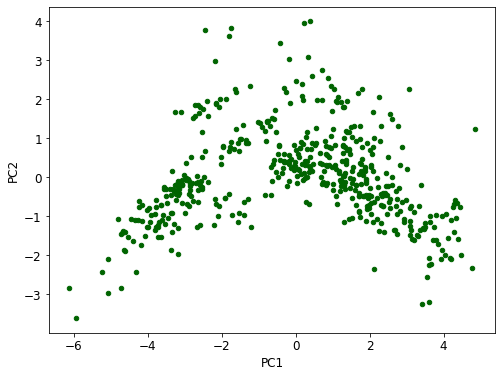

In [18]:
#7. plot two principal complonents

plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12
ax1 = df_pca.plot.scatter(x='PC1',y='PC2',c='DarkGreen')

In [19]:
#8. Vectorize features and target together for model developmen

output = assembler.transform(dataset)

#input vs output
finalized_data = output.select('features','medv')

finalized_data.show()

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
|[0.02985,0.0,2.18...|28.7|
|[0.08829,12.5,7.8...|22.9|
|[0.14455,12.5,7.8...|27.1|
|[0.21124,12.5,7.8...|16.5|
|[0.17004,12.5,7.8...|18.9|
|[0.22489,12.5,7.8...|15.0|
|[0.11747,12.5,7.8...|18.9|
|[0.09378,12.5,7.8...|21.7|
|[0.62976,0.0,8.14...|20.4|
|[0.63796,0.0,8.14...|18.2|
|[0.62739,0.0,8.14...|19.9|
|[1.05393,0.0,8.14...|23.1|
|[0.7842,0.0,8.14,...|17.5|
|[0.80271,0.0,8.14...|20.2|
|[0.7258,0.0,8.14,...|18.2|
+--------------------+----+
only showing top 20 rows



In [20]:

#9. Split dataset into training and testing dataset

#split train & test data
train_data,test_data = finalized_data.randomSplit([0.8,0.2])

In [21]:
#10. Fit model for linear regression
#train model

regressor = LinearRegression(featuresCol='features', labelCol='medv')

#learn to fit the model from train set
regressor = regressor.fit(train_data)

In [22]:
#11. Find out model coefficients and intercept

#model coefficient

coeff = regressor.coefficients

#x & Yintercept

intr = regressor.intercept

print("The coefficient of the model is : %a" %coeff)
print("The intercept of the model is : %f" %intr)

    

The coefficient of the model is : DenseVector([-0.1108, 0.0323, 0.02, 2.96, -18.3293, 4.6698, -0.014, -1.5135, 0.265, -0.011, -0.9267, 0.008, -0.4525])
The intercept of the model is : 31.597466


In [23]:
#11. Evaluate model for test dataset

pred = regressor.evaluate(test_data)
#predict the model

pred.predictions.show()

+--------------------+----+------------------+
|            features|medv|        prediction|
+--------------------+----+------------------+
|[0.0136,75.0,4.0,...|18.9|14.901381566681966|
|[0.01381,80.0,0.4...|50.0| 40.95565497704436|
|[0.01501,90.0,1.2...|50.0| 45.10265640346027|
|[0.02187,60.0,2.9...|31.1|32.212019280500854|
|[0.02498,0.0,1.89...|16.5| 22.45391893335252|
|[0.02543,55.0,3.7...|23.9|27.253903813331085|
|[0.02731,0.0,7.07...|21.6|  24.9119398038659|
|[0.02763,75.0,2.9...|30.8|30.826353243845727|
|[0.02875,28.0,15....|25.0|28.931924594679437|
|[0.03049,55.0,3.7...|31.2| 28.46346167889101|
|[0.03113,0.0,4.39...|17.5|16.679191157820696|
|[0.03237,0.0,2.18...|33.4| 28.95472942550252|
|[0.03548,80.0,3.6...|20.9|20.865275777490872|
|[0.04011,80.0,1.5...|33.3| 35.85992769386079|
|[0.0456,0.0,13.89...|23.3|26.870188611748727|
|[0.0459,52.5,5.32...|22.3| 26.47002870984985|
|[0.04684,0.0,3.41...|22.6|  27.2726056193954|
|[0.05059,0.0,4.49...|23.9| 25.13671176901051|
|[0.05188,0.0

In [24]:
#14. Perform further analysis for better interpretation of model results.
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol="medv", predictionCol='prediction', metricName='rmse')

#root mean square error
rmse = eval.evaluate(pred.predictions)
print("rmse: %.3f" % rmse)

#mean square error
mse = eval.evaluate(pred.predictions,{eval.metricName: "mse"})
print("MSE: %.3f" % mse)

#mean absolute error
mae = eval.evaluate(pred.predictions,{eval.metricName: "mae"})
print("MAE: %.3f" % mae)

#r2 - coefficient
r2 = eval.evaluate(pred.predictions,{eval.metricName: "r2"})
print("r2: %.3f" % r2)

rmse: 5.258
MSE: 27.645
MAE: 3.393
r2: 0.673
